#Introduction
This notebook is prepared as part of the submission for the "Natural Language Processing with Disaster Tweets" Kaggle competition. The following sections will outline the competition context, our objectives, and a brief description of the dataset provided.

The repository for this Project: https://github.com/MedGhassen/Natural-Language-Processing-with-Disaster-Tweets.git




##Competition Overview
The "Natural Language Processing with Disaster Tweets" competition challenges participants to build a machine learning model that predicts which Tweets are about real disasters and which ones are not. This is crucial for effective disaster response and management. The competition is evaluated based on the F1 score, combining precision and recall.

##Objective
The primary objective of this project is to develop a model that accurately classifies tweets into two categories: those that are about real disasters and those that are not. Success in this task can significantly aid emergency services and disaster response teams in timely and effective action. The project involves data preprocessing, exploratory analysis, feature engineering, model selection, and evaluation to meet the competition's scoring metric.


##Data Description
The dataset for the "Natural Language Processing with Disaster Tweets" competition includes a training set and a test set of tweets. Each tweet is labeled as '1' if it is about a real disaster and '0' otherwise. The dataset contains features such as the text of the tweet, keyword, and location from which the tweet was sent. The challenge involves processing and analyzing text data, handling imbalanced classes, and employing NLP techniques to predict the labels accurately.

#Data Loading and Preliminary data analysis


##Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer
import tensorflow as tf
from transformers import TFBertForSequenceClassification
import re
from tensorflow.keras.optimizers import Adamax
import tensorflow as tf
import tensorflow_hub as hub
!pip3 install tensorflow_text
import tensorflow_text as text
!pip3 install tf-models-official
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 34.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=7b2db5a8df270b05fe8e502b09d7377648b6d47ca2f5b0e07d514da415460c02
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


##Load data

We will download the data from Kaggle. Please note the code for downloading is copied from kaggle.

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F17777%2F869809%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T001646Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D155aec2a448980f50b2e12f17d02a8f84e34d6c0896241a4860ab42aa36b8021ce064a58d9a31e82bbedfe5083a4dff571346950ed1fd0830004e7db1527facd6d693eea13e6da3974a88d1af5a2b78addf05822d807df7ccda456716447fb83c9bd72ddcb815baea17d6bdfb7de0b8cc0adf4bfb2d4e02891f483bd1bb928b7d1a817c2786c3ab1810d491f2bb82ddbf12b5fa5758606b672693261fcb663e1d49ecb9acd762fd015d20396e9dd49a42606bf1aceca48aad10e01bf563047abcab0a29c95a3fec4bb5ccbb52586706209c716207c87638179ab770c0f22ff1786248c6648d351bb956f9df77c701bf134d0c3e53d74ad727c55822ecdf383ae'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: nlp-getting-started
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


We will load the training dataset into a dataframe.

In [78]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [79]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


##Preliminary Data Analysis


We check the training data set.

In [6]:
# Display the first few rows of the data
print(train_data.head())
# Check for missing values
print(train_data.isnull().sum())
# Statistical summary
print(train_data.describe())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


As we can see the keyword and location are missing for many records:
- keyword: 61 records have missing keyword from 7613 rows.
- location: 2533 records have missing location from 7613 rows.

Let's check the test data set.

In [7]:
# Display the first few rows of the data
print(test_data.head())
# Check for missing values
print(test_data.isnull().sum())
# Statistical summary
print(test_data.describe())


   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
id             0
keyword       26
location    1105
text           0
dtype: int64
                 id
count   3263.000000
mean    5427.152927
std     3146.427221
min        0.000000
25%     2683.000000
50%     5500.000000
75%     8176.000000
max    10875.000000


As we can see the keyword and location are missing for many records:
- keyword: 26 records have missing keyword from 3263 rows.
- location: 1105 records have missing location from 3263 rows.

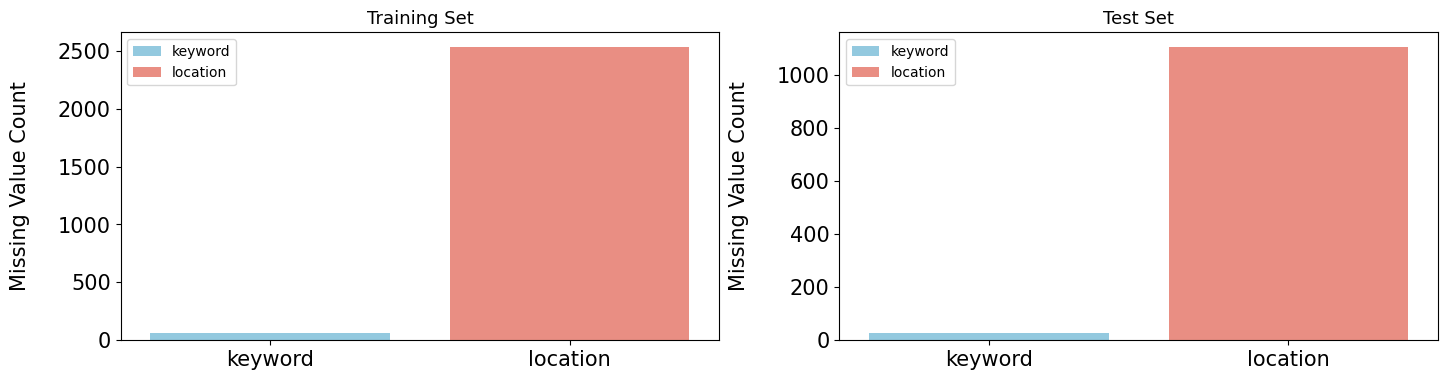

In [8]:
# Define the missing columns and dataframes in a dictionary
missing_cols = ['keyword', 'location']
dataframes = {'Training Set': train_data, 'Test Set': test_data}
colors = ['skyblue', 'salmon']  # Define colors

# Create subplots
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

# Iterate through dataframes and axes simultaneously
for ax, (title, df) in zip(axes, dataframes.items()):
    # Plot each missing column with a different color
    for i, col in enumerate(missing_cols):
        sns.barplot(x=[col], y=[df[col].isnull().sum()], ax=ax, color=colors[i], label=col)
    ax.set_ylabel('Missing Value Count', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(title, fontsize=13)
    ax.legend()  # Add legend to differentiate between 'keyword' and 'location'

plt.show()

Let's check the number of unique values for the location and keyword.

In [9]:
# Define the columns and dataframes in a dictionary for easy access
columns = ['keyword', 'location']
dataframes = {'Training': train_data, 'Test': test_data}

# Iterate through each column and dataframe to print the number of unique values
for col in columns:
    unique_values = {df_name: df[col].nunique() for df_name, df in dataframes.items()}
    print(f'Number of unique values in {col} = {unique_values["Training"]} (Training) - {unique_values["Test"]} (Test)')


Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


We can see the location is a very dirty column, it's messing for almost 33% of the training data and almost 34% of the test data. It also have a lot of unique values. We **will not** be using the Location as training feature.

On the other hand, the keyword seems to be usefull.


#Exploratory Data Analysis (EDA)


##Distribution of target variable to understand the balance between classes

Analyzing the distribution of the target variable helps understand if there's a balance between classes (such as 'disaster' vs 'non-disaster' tweets). If one class significantly outweighs the other, it indicates an imbalanced dataset, which can impact model performance and might require specific strategies like resampling. It's crucial for guiding our modeling approach and for evaluating model performance fairly.

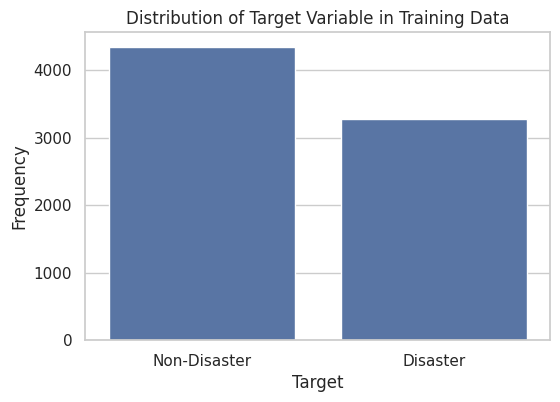

In [10]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a count plot
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable in Training Data')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
plt.show()

##Frequency of keywords and their relationship with the target variable
To analyze the frequency of keywords and their relationship with the target variable, we can create visualizations like bar plots or heatmaps. This involves grouping data by keywords, calculating the frequency of each keyword in each class of the target variable, and plotting these frequencies to observe any noticeable patterns or trends. This helps identify if certain keywords are strongly associated with one class over the other, which can be crucial for model feature engineering and interpretation.





<ipython-input-11-26e22e6f3c2d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='keyword', data=keyword_grouped.head(30), palette='coolwarm')


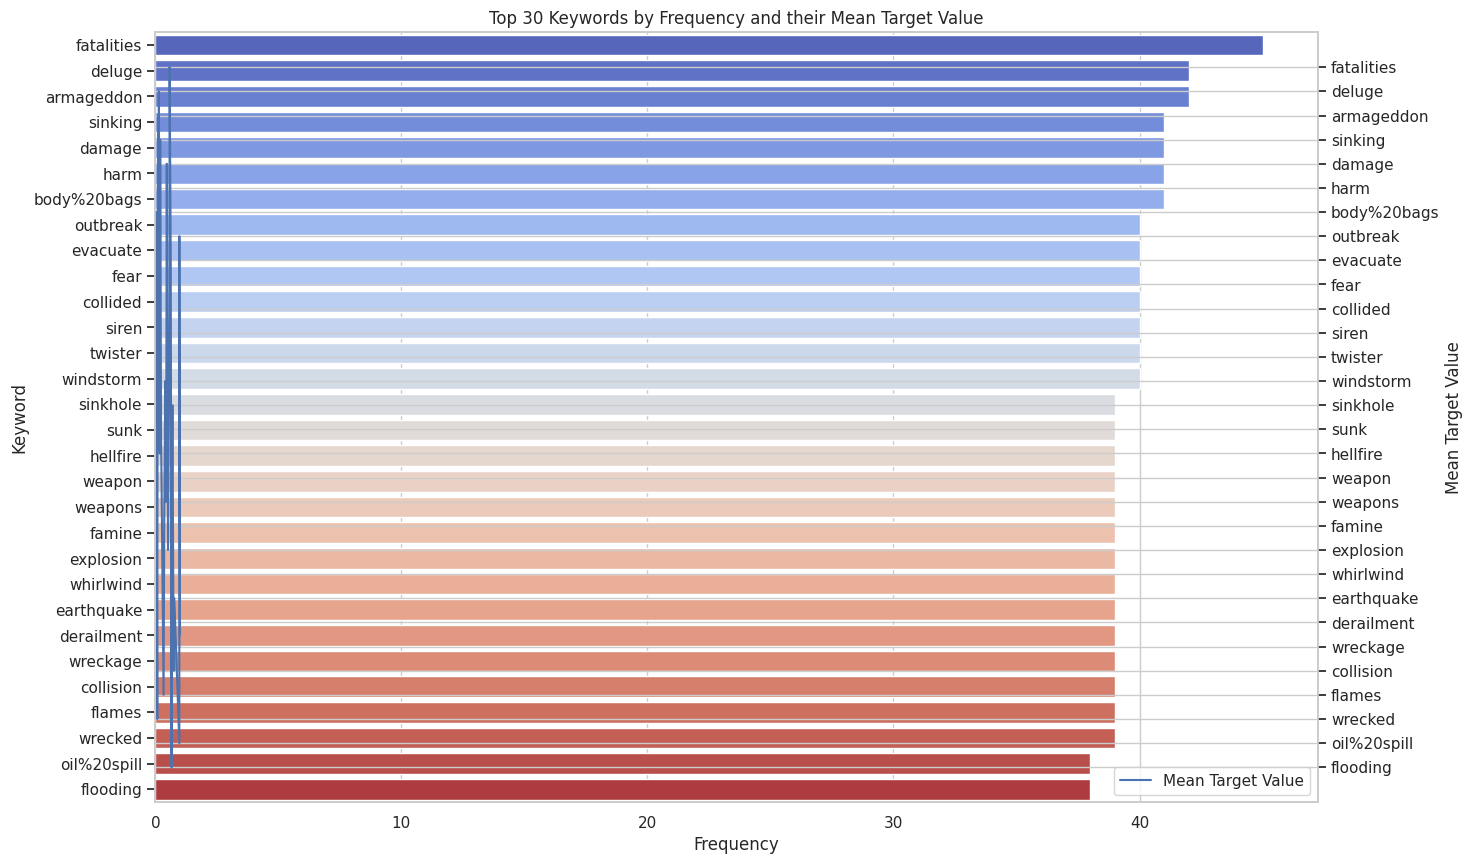

In [11]:
# Group by keyword and calculate the mean target value for each keyword
keyword_grouped = train_data.groupby('keyword')['target'].agg(['count', 'mean']).reset_index().sort_values('count', ascending=False)

# Plotting
plt.figure(figsize=(15, 10))
sns.barplot(x='count', y='keyword', data=keyword_grouped.head(30), palette='coolwarm')
plt.title('Top 30 Keywords by Frequency and their Mean Target Value')
plt.xlabel('Frequency')
plt.ylabel('Keyword')

# Create a twin x-axis to plot the mean target value
ax2 = plt.gca().twinx()
sns.lineplot(y=keyword_grouped.head(30)['keyword'], x=keyword_grouped.head(30)['mean'], ax=ax2, color='b', label='Mean Target Value')
ax2.set_ylabel('Mean Target Value')
ax2.legend(loc='lower right')

plt.show()

The plot visualizes the top 30 keywords by frequency and their mean target value. Keywords closer to the top, with darker blue bars, have lower frequencies but are more strongly associated with disaster tweets (higher mean target value). In contrast, keywords at the bottom, with darker red bars, are more frequent but less likely to indicate a disaster tweet. This suggests that certain keywords are highly indicative of the content's nature, highlighting the importance of keyword selection in predicting disaster-related tweets.

##Text analysis, including word cloud for common words, n-gram analysis to find common phrases, and sentiment analysis

Text analysis for the dataset can be performed as follows:

- **Word Cloud**: Generate a word cloud to visualize the most common words in the dataset, highlighting the predominant themes or subjects.

- **N-Gram Analysis**: Conduct an n-gram analysis to identify common phrases (combinations of 2 or more words) that appear frequently together. This helps in understanding context and common patterns in the data.

- **Sentiment Analysis**: Perform sentiment analysis to gauge the overall sentiment of the tweets, categorizing them into positive, neutral, or negative based on the language used. This could provide insight into the general tone of tweets associated with real disasters versus non-disasters.

Each of these analyses provides different insights into the textual data, aiding in comprehensive understanding and feature engineering for predictive modeling.

**Word Cloud**

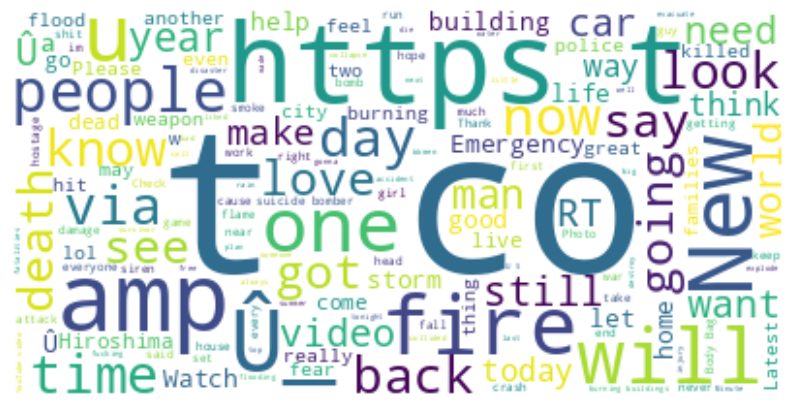

In [12]:
# Combine all tweets into a single string
text = ' '.join(tweet for tweet in train_data['text'])

# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


**N-Gram Analysis**

In [13]:
# Instantiate a CountVectorizer for bi-grams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X2 = vectorizer.fit_transform(train_data['text'])

# Convert to DataFrame for easier manipulation
bi_grams = pd.DataFrame(X2.toarray(), columns=vectorizer.get_feature_names_out())

# Sum columns to find most common bi-grams
common_bi_grams = bi_grams.sum().sort_values(ascending=False).head(10)
print(common_bi_grams)

û_ http                217
burning buildings       60
suicide bomber          59
youtube video           43
video http              42
liked youtube           42
northern california     41
cross body              40
oil spill               39
suicide bombing         36
dtype: int64


# Pre-Processing and feature engineering



##Pre-Processing

In [14]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [15]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Try encoder

In [16]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611874  0.3667385   0.1523372   0.6550446
  0.9681154  -0.94862705  0.0021616  -0.9877732   0.06842716 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894634   0.34321257  0.33231494 ...  0.21300837  0.7102077
  -0.05771141]
 [-0.28742063  0.31981015 -0.23018579 ...  0.58455044 -0.21329722
   0.72692055]
 [-0.66157013  0.6887687  -0.87433    ...  0.10877256 -0.26173246
   0.47855335]
 ...
 [-0.2256114  -0.2892561  -0.0706443  ...  0.47565973  0.83277154
   0.40025324]
 [-0.29824266 -0.27473152 -0.05450485 ...  0.48849776  1.0955359
   0.18163376]
 [-0.4437817   0.00930699  0.07223739 ...  0.17290172  1.1833248
   0.07898028]]


We will define the preprocessing layer as part of the model.

#Model Building

We will start by using a BERT based model.
The BERT (Bidirectional Encoder Representations from Transformers) based model, especially when used in natural language processing tasks, has several distinctive features:

1. **Bidirectional Training**: Unlike previous models that process words in order one after the other, BERT reads the entire sequence of words at once. This allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

2. **Transformer Architecture**: BERT is based on the Transformer architecture, which uses attention mechanisms to understand the context of each word relative to all other words in the sentence, rather than relying on the sequential order of the words.

3. **Pre-training and Fine-tuning**: BERT is first pre-trained on a large corpus of text in an unsupervised manner (i.e., without specific task-oriented labels). This involves learning by predicting words based on their context and by predicting the relationship between sentences. Then, for specific tasks like classification or question answering, BERT is fine-tuned with labeled data.

4. **WordPiece Tokenization**: BERT uses a technique called WordPiece tokenization, which breaks words down into smaller units (tokens) to deal with the vocabulary problem in NLP. This allows BERT to understand better and process less common words.

5. **Handling of 'Out of Vocabulary' Words**: Due to its tokenization method, BERT can effectively handle words that were not seen during training, by breaking them down into known subwords.

6. **Large Scale and Deep**: BERT models are typically large, consisting of several layers of transformers (the original BERT model has 12 for the base version and 24 for the large version), which enables them to capture complex language nuances.

7. **Versatility and Adaptability**: BERT can be adapted and fine-tuned for a wide range of language tasks beyond text classification, such as question answering, named entity recognition, and sentiment analysis.

8. **Contextual Embeddings**: Unlike previous word embedding techniques like Word2Vec or GloVe, which generate a single word embedding for each word in the vocabulary, BERT generates embeddings that are dynamically informed by the words around them. This means that the word "bank" would have different embeddings in "river bank" and "savings bank".

These features make BERT particularly powerful for a range of NLP tasks, contributing to its widespread adoption in the field. If there's a specific aspect of the BERT-based model used in your notebook that you'd like to know more about, let me know, and I can provide additional details.

## Define the model

In [114]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [115]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7417418]], shape=(1, 1), dtype=float32)


## Plot the model architecture

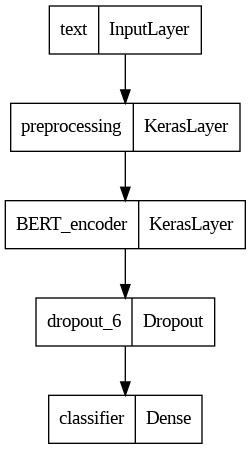

In [116]:
tf.keras.utils.plot_model(classifier_model)

## define the loss function and Optimizer

In [103]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [104]:
!pip3 install tf-models-official
from official.nlp import optimization  # to create AdamW optimizer

epochs = 10
steps_per_epoch = train_data.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [117]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [106]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data['text'],train_data['target'], stratify=train_data['target'], test_size=0.2, random_state=42)
X_train.head(4)

6234    Sassy city girl country hunk stranded in Smoky...
326     God's Kingdom (Heavenly Gov't) will rule over ...
997     Mopheme and Bigstar Johnson are a problem in t...
7269            @VixMeldrew sounds like a whirlwind life!
Name: text, dtype: object

In [17]:
def get_callbacks(model_name):
    callbacks = []

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
      f'{model_name}.h5',  # Path where to save the model
      monitor='val_loss',
      verbose=1,
      save_best_only=True,
      mode='min',
      save_weights_only=True,
      overwrite=True
    )

    callbacks.append(checkpoint)

    return callbacks

## Train the Model
We will train the model for 10 epochs first and observe the Validation and training Loss and Accuracy.

In [119]:
print(f'Training model with {tfhub_handle_encoder}')
callbacks = get_callbacks('bert_v1')
history = classifier_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[callbacks]
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 0.4862 - binary_accuracy: 0.7843
Epoch 1: val_loss improved from inf to 0.38538, saving model to bert_v1.h5
191/191 [==============================] - 52s 248ms/step - loss: 0.4862 - binary_accuracy: 0.7843 - val_loss: 0.3854 - val_binary_accuracy: 0.8306
Epoch 2/10
191/191 [==============================] - ETA: 0s - loss: 0.3723 - binary_accuracy: 0.8399
Epoch 2: val_loss did not improve from 0.38538
191/191 [==============================] - 47s 244ms/step - loss: 0.3723 - binary_accuracy: 0.8399 - val_loss: 0.3982 - val_binary_accuracy: 0.8418
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.3268 - binary_accuracy: 0.8617
Epoch 3: val_loss did not improve from 0.38538
191/191 [==============================] - 47s 248ms/step - loss: 0.3268 - binary_accuracy: 0.8617 - val_loss: 0.4295 - val_binary_acc

In [120]:
history.history

{'loss': [0.486163467168808,
  0.3723164200782776,
  0.3268018960952759,
  0.27852264046669006,
  0.23032785952091217,
  0.19581080973148346,
  0.1656910479068756,
  0.1377447247505188,
  0.12576818466186523,
  0.1012955904006958],
 'binary_accuracy': [0.7843163013458252,
  0.8399015069007874,
  0.8617405295372009,
  0.8868637084960938,
  0.9085385799407959,
  0.9238095283508301,
  0.935960590839386,
  0.9474548697471619,
  0.9518883228302002,
  0.9614121317863464],
 'val_loss': [0.3853778541088104,
  0.3982357084751129,
  0.42954838275909424,
  0.467474102973938,
  0.49467846751213074,
  0.552555501461029,
  0.5531550645828247,
  0.6826388239860535,
  0.7324653267860413,
  0.8382974863052368],
 'val_binary_accuracy': [0.8305975198745728,
  0.8417596817016602,
  0.8351936936378479,
  0.8260012865066528,
  0.8233749270439148,
  0.8200919032096863,
  0.8319107294082642,
  0.818122148513794,
  0.813525915145874,
  0.7957977652549744]}

## Plot the Training and Validation Loss and Accuracy

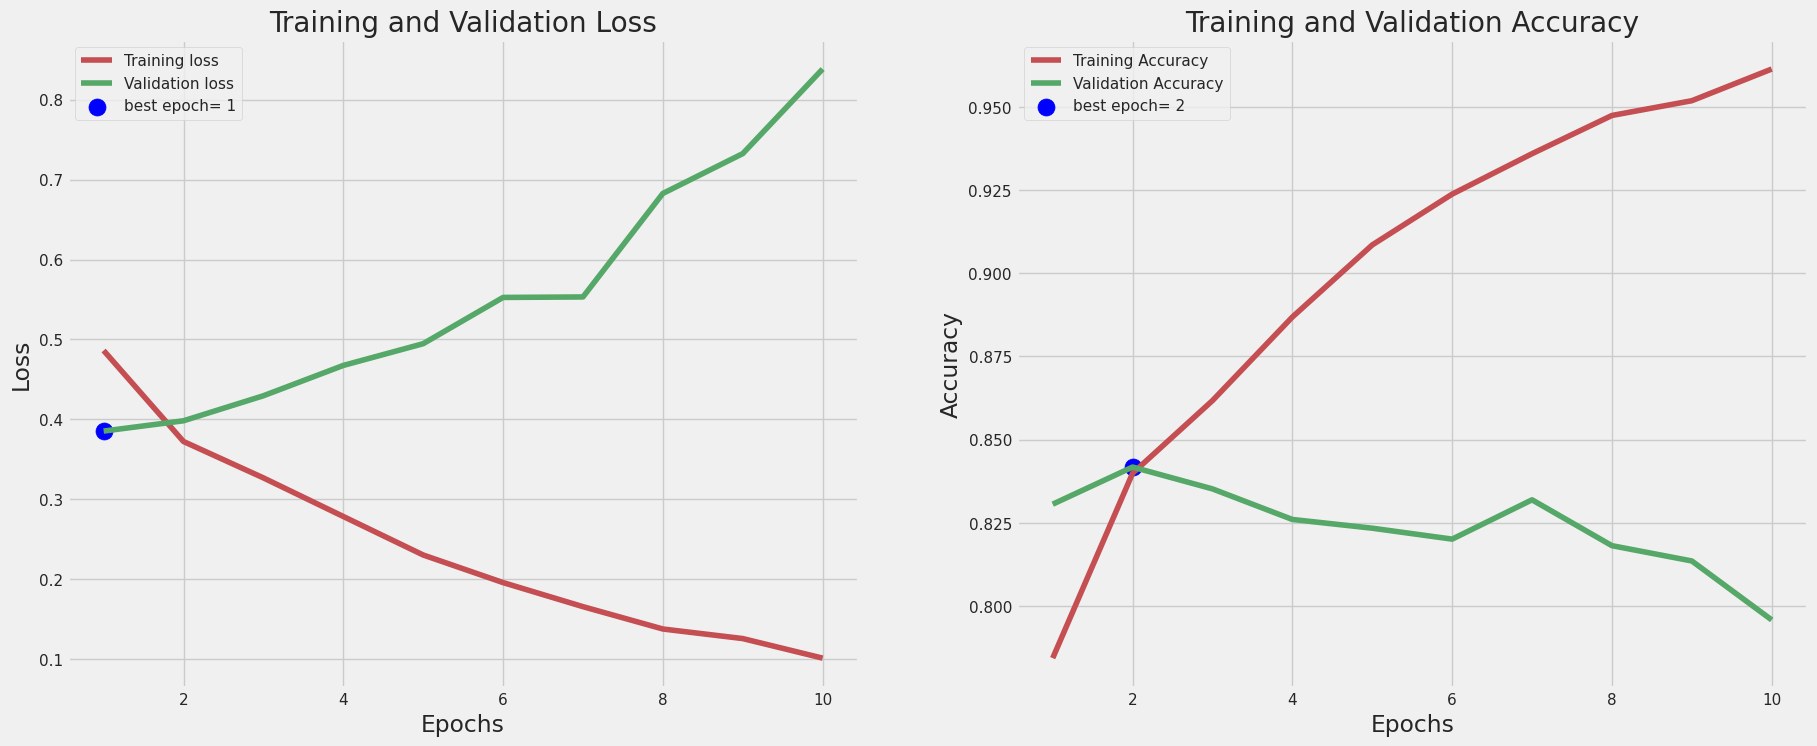

In [121]:
def plot_loss_accuracy_binary(history):
  tr_acc = history.history['binary_accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_binary_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout
  plt.show()

plot_loss_accuracy_binary(history)

## Submit to Kaggel

In [122]:
classifier_model.load_weights('bert_v1.h5')
predictions = (classifier_model.predict(test_data['text']) > 0.5).astype(int)
predictions

102/102 [==============================] - 11s 100ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [123]:
# Map the prediction to ids
results = pd.DataFrame({
    'id': test_data['id'],  # Make sure this is the correct column name for your IDs
    'target': predictions.flatten()
})
results.to_csv('/kaggle/results_BERT_V1.csv', index=False)

In [124]:
results

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,1


In [52]:
(results['target'] == 1).sum()

1288

## Kaggel results

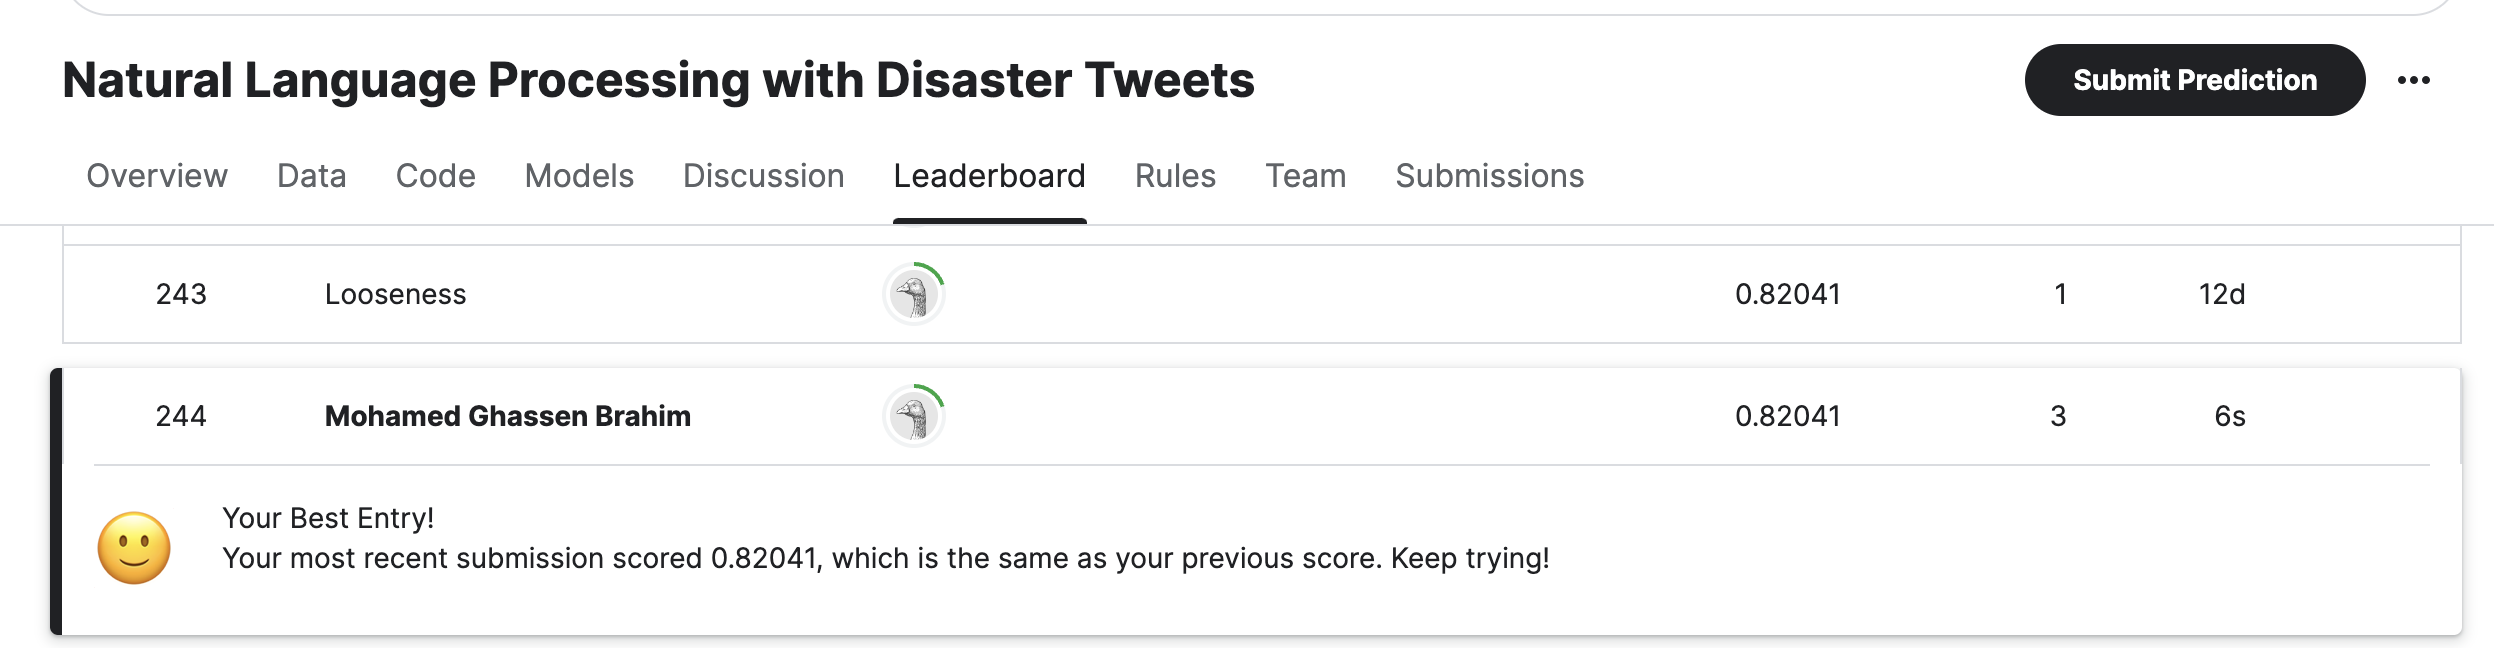

## Let's try with LSTM

LSTM (Long Short-Term Memory) based models are a special kind of RNN (Recurrent Neural Network) capable of learning long-term dependencies. They were introduced to overcome the shortcomings of traditional RNNs, particularly the vanishing gradient problem. Here are some of the key features of LSTM-based models:

1. **Memory Cells**: LSTMs contain memory cells that enable them to store and access information over long periods. Each cell has the ability to maintain its state over time, making LSTMs particularly suitable for tasks involving sequential data, such as time series analysis or language modeling.

2. **Gates Mechanism**: LSTMs use a system of gates to control the flow of information. These include:
   - **Forget Gate**: Decides what information should be thrown away or kept from the previous state.
   - **Input Gate**: Decides which new information is added to the cell state.
   - **Output Gate**: Determines what the next hidden state should be, which is based on the cell state and will be passed on to the next time step.

3. **Backpropagation Through Time (BPTT)**: LSTMs are trained using BPTT, which allows gradients to flow backward through time to update the model’s parameters. This is crucial for learning from earlier parts of the input sequence.

4. **Handling of Long-Term Dependencies**: Thanks to their structure, LSTMs can remember information for long periods, which is their main advantage over simple RNNs. This is particularly useful in applications where the gap between relevant information and the point where it is needed is large.

5. **Sequence to Sequence Processing**: LSTMs can process entire sequences of data (like a sentence or a time series), making them suitable for applications like machine translation, speech recognition, and text generation.

6. **Variable Length Input**: LSTMs can handle inputs of varying lengths, which is essential for processing sentences of different sizes or time series data of varying intervals.

7. **Bidirectional LSTMs**: While standard LSTMs process data from past to future, Bidirectional LSTMs (BiLSTMs) process data in both directions with two separate hidden layers, which can provide additional context and improve model performance on certain tasks.

8. **Stacked LSTMs**: Multiple layers of LSTMs can be stacked to form a deeper network. This can help the model to learn more complex patterns but at the cost of increased computational complexity.

LSTM-based models have been widely used in natural language processing, speech recognition, and other areas where understanding long-term dependencies is crucial. Their ability to remember and connect past information with present tasks makes them especially powerful for sequential data analysis.

In [126]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Constants for text processing
VOCAB_SIZE = 10000  # consider top 10,000 words in dataset
MAX_LENGTH = 100  # maximum length of all sequences
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOK = "<OOV>"  # for out-of-vocabulary words

# Tokenize sentences
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)  # where X_train is our training text data
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

val_sequences = tokenizer.texts_to_sequences(X_test)  # where X_test is our validation text data
val_padded = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(VOCAB_SIZE, 64, input_length=MAX_LENGTH),  # 64 is the embedding dimension
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(24, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

In [128]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [130]:
num_epochs = 10
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # to prevent overfitting
callbacks = get_callbacks('lstm_v1')
callbacks.append(early_stopping)

history = model.fit(
    train_padded, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(val_padded, y_test),
    callbacks=[callbacks]
)

Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 0.5302 - accuracy: 0.7458
Epoch 1: val_loss improved from inf to 0.45363, saving model to lstm_v1.h5
191/191 [==============================] - 114s 592ms/step - loss: 0.5302 - accuracy: 0.7458 - val_loss: 0.4536 - val_accuracy: 0.8083
Epoch 2/10
191/191 [==============================] - ETA: 0s - loss: 0.3371 - accuracy: 0.8658
Epoch 2: val_loss improved from 0.45363 to 0.45016, saving model to lstm_v1.h5
191/191 [==============================] - 104s 542ms/step - loss: 0.3371 - accuracy: 0.8658 - val_loss: 0.4502 - val_accuracy: 0.8102
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9133
Epoch 3: val_loss did not improve from 0.45016
191/191 [==============================] - 100s 521ms/step - loss: 0.2349 - accuracy: 0.9133 - val_loss: 0.5733 - val_accuracy: 0.7925
Epoch 4/10
191/191 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9429
Epoch 4: v

In [133]:
history.history

{'loss': [0.5301918387413025,
  0.33705782890319824,
  0.23487822711467743,
  0.17227141559123993,
  0.12045763432979584],
 'accuracy': [0.7458128333091736,
  0.8658456206321716,
  0.9133005142211914,
  0.9428571462631226,
  0.9599342942237854],
 'val_loss': [0.453631728887558,
  0.4501635730266571,
  0.5733015537261963,
  0.740882933139801,
  0.8427218198776245],
 'val_accuracy': [0.8082731366157532,
  0.8102429509162903,
  0.7925148010253906,
  0.7734733819961548,
  0.780039370059967]}

In [60]:
def plot_loss_accuracy(history):
  tr_acc = history.history['accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout
  plt.show()

plot_loss_accuracy(history)

In [137]:
model.load_weights('lstm_v1.h5')

# Prepare the test data: Tokenize and pad
test_sequences = tokenizer.texts_to_sequences(test_data['text'])  # Replace 'text' with the name of your text column
test_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

# Predicting the target
predictions = model.predict(test_padded)
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary class labels

# If you need to attach these predictions back to your test data:
test_data['target'] = predicted_classes
test_data

102/102 [==============================] - 12s 103ms/step


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [138]:
results = pd.DataFrame({
    'id': test_data['id'],
    'target': test_data['target']
})
results.to_csv('/kaggle/results_lstm_v1.csv', index=False)

Our LSTM Model scores 0.7919 which is lower than the BERT based model.

## Let's try a different transformers based model

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

BATCH = 32
SEED = 42  # Assuming SEED is defined
TARGET = 'target'  # Assuming TARGET is the label column name

# Combine text data and create tf.data.Dataset objects
def create_dataset(data, labels=None, batch_size=BATCH, is_test=False):
    if not is_test:
        ds = tf.data.Dataset.from_tensor_slices(
            ( data, labels))
        ds = ds.shuffle(buffer_size=len(data)).batch(batch_size)
    else:
        ds = tf.data.Dataset.from_tensor_slices(
            (data, labels))
        ds = ds.batch(batch_size)
    return ds

train_tf = create_dataset(X_train, y_train)
test_tf = create_dataset(X_test, y_test)

# Text vectorization
max_length = 165
max_tokens = 20_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_length
)

# Adapt TextVectorization layer
text_vectorization.adapt(train_tf.map(lambda text, target: text))

# Retrieve the vocabulary and convert to NumPy array
vocab = np.array(text_vectorization.get_vocabulary())
print("Vocabulary size =", len(vocab))

# Vectorize datasets
train_tf = train_tf.map(lambda text, target: (text_vectorization(text), target),
                        num_parallel_calls=tf.data.AUTOTUNE)
test_tf = test_tf.map(lambda text, target: (text_vectorization(text), target),
                      num_parallel_calls=tf.data.AUTOTUNE)

Vocabulary size = 19442


In [71]:
def print_sample(data_obj):
    for sample, target in data_obj.take(1):  # Simplified to use .take(1)
        print("1st sample:", sample[0].numpy(), "\n")
        print("2nd sample:", sample[1].numpy(), "\n")
        print("3rd sample:", sample[2].numpy(), "\n")

print_sample(train_tf)

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = models.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        })
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "output_dim": self.output_dim
        })
        return config

inputs = layers.Input(shape=(max_length,), dtype="int64")
pos_embed = PositionalEmbedding(sequence_length=max_length, input_dim=max_tokens, output_dim=256)(inputs)
encoded = TransformerEncoder(embed_dim=256, dense_dim=32, num_heads=8)(pos_embed)

x = layers.GlobalMaxPooling1D()(encoded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.98,epsilon=1e-9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


1st sample: [  894   250 16562  1020     4   935  1717    88 18707   324   250  4298
   478     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   

In [72]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # to prevent overfitting
callbacks = get_callbacks('transformers_v1')
callbacks.append(early_stopping)
batch_size = 1024
epochs = 100
history = model.fit(train_tf,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=test_tf,
                    callbacks=[callbacks])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.2505 - accuracy: 0.5064
Epoch 1: val_loss improved from inf to 0.71302, saving model to transformers_v1.h5
191/191 [==============================] - 19s 82ms/step - loss: 1.2505 - accuracy: 0.5064 - val_loss: 0.7130 - val_accuracy: 0.5693
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.0596 - accuracy: 0.5342
Epoch 2: val_loss improved from 0.71302 to 0.68129, saving model to transformers_v1.h5
191/191 [==============================] - 11s 57ms/step - loss: 1.0596 - accuracy: 0.5342 - val_loss: 0.6813 - val_accuracy: 0.5909
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 0.8997 - accuracy: 0.5374
Epoch 3: val_loss improved from 0.68129 to 0.67332, saving model to transformers_v1.h5
191/191 [==============================] - 10s 54ms/step - loss: 0.8997 - accuracy: 0.5374 - val_loss: 0.6733 - val_accuracy: 0.5778
Epoch 4/100
191/191 [==============================] 

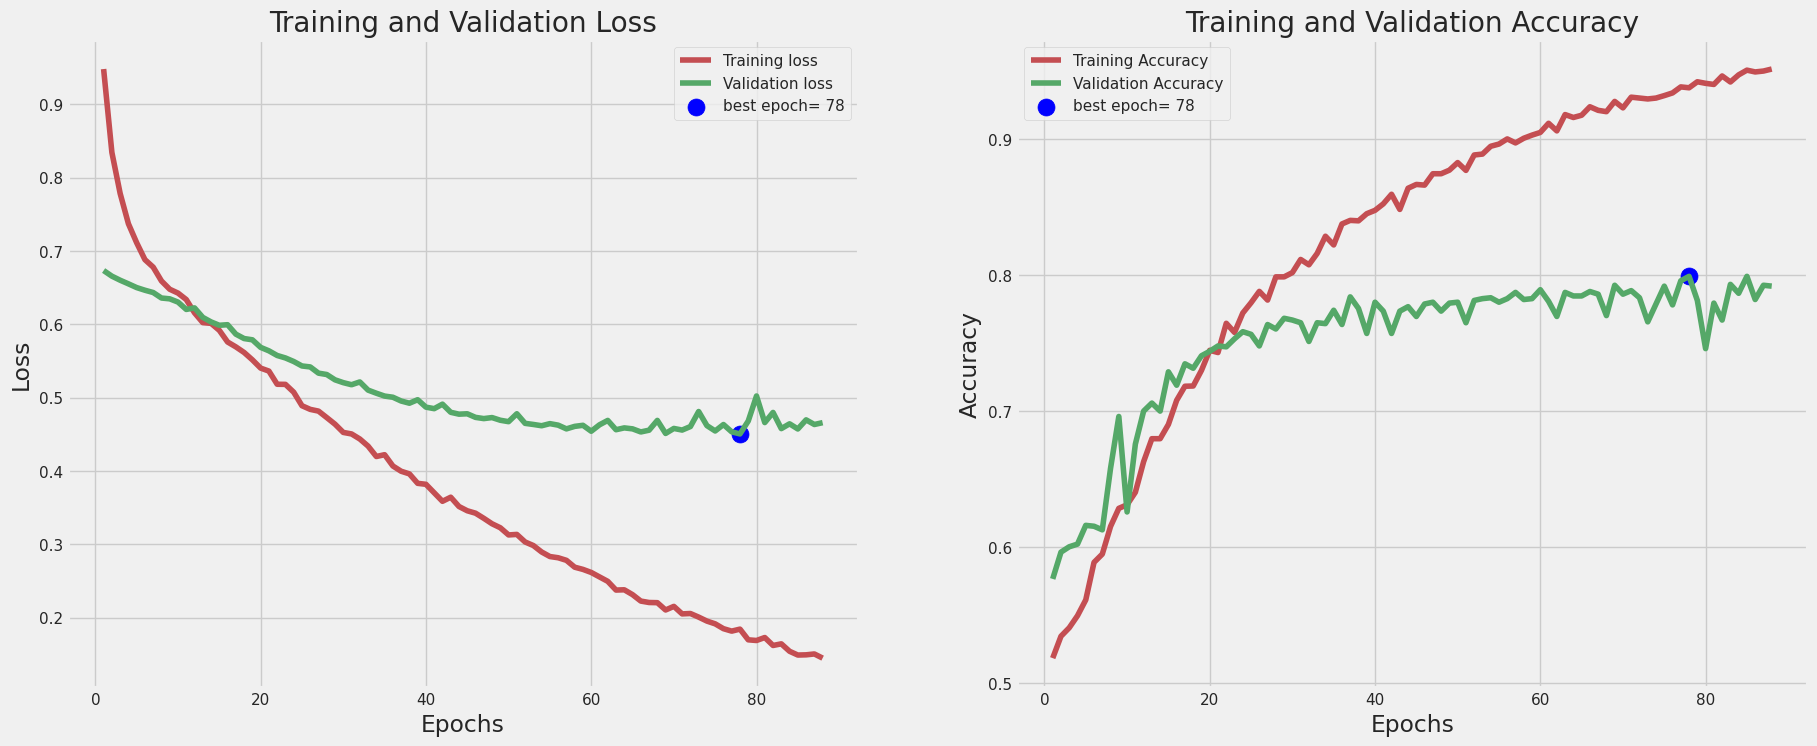

In [65]:
plot_loss_accuracy(history)

In [68]:
model.load_weights('transformers_v1.h5')
predictions = (model.predict(text_vectorization(test_data['text'])) > 0.5).astype(int)
# Map the prediction to ids
results = pd.DataFrame({
    'id': test_data['id'],  # Make sure this is the correct column name for your IDs
    'target': predictions.flatten()
})
results.to_csv('/kaggle/results_transformers_v1.csv', index=False)

102/102 [==============================] - 2s 17ms/step


In [69]:
results

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


The model performs 0.79436.

## Let's fine tune the BERT based mode

In [84]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define handles for preprocessing and BERT encoder from TensorFlow Hub
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']

    # Add additional dense layers with regularization
    net = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
    net = tf.keras.layers.Dropout(0.2)(net)  # Adjust dropout rate
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)  # Use sigmoid for binary classification

    return tf.keras.Model(text_input, net)

# Create the model
model = build_classifier_model()

# Compile the model
optimizer = Adam(learning_rate=5e-5)  # Set learning rate
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3),  # Stop training when `val_loss` is no longer improving
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')  # Save the best model
]

# Train the model (replace `train_dataset` and `validation_dataset` with your actual dataset variables)
history = model.fit(
    X_train,
    y_train,  # Your training dataset
    validation_data=(X_test, y_test),  # Your validation dataset
    epochs=20,  # Set the number of epochs
    batch_size=128,  # Set the batch size
    callbacks=callbacks  # Add callbacks to the training
)


Epoch 1/20
48/48 [==============================] - 89s 2s/step - loss: 2.5180 - accuracy: 0.7424 - val_loss: 2.3789 - val_accuracy: 0.8135
Epoch 2/20
48/48 [==============================] - 72s 1s/step - loss: 2.2940 - accuracy: 0.8404 - val_loss: 2.2574 - val_accuracy: 0.8313
Epoch 3/20
48/48 [==============================] - 74s 2s/step - loss: 2.1565 - accuracy: 0.8670 - val_loss: 2.2016 - val_accuracy: 0.8273
Epoch 4/20
48/48 [==============================] - 75s 2s/step - loss: 2.0119 - accuracy: 0.8903 - val_loss: 2.1339 - val_accuracy: 0.8378
Epoch 5/20
48/48 [==============================] - 71s 1s/step - loss: 1.8727 - accuracy: 0.9199 - val_loss: 2.1246 - val_accuracy: 0.8188
Epoch 6/20
48/48 [==============================] - 64s 1s/step - loss: 1.7491 - accuracy: 0.9391 - val_loss: 2.2046 - val_accuracy: 0.7919
Epoch 7/20
48/48 [==============================] - 69s 1s/step - loss: 1.6325 - accuracy: 0.9522 - val_loss: 2.0801 - val_accuracy: 0.8207
Epoch 8/20
48/48 [==

In [86]:
model.load_weights('best_model.h5')
predictions = (model.predict(test_data['text']) > 0.5).astype(int)
# Map the prediction to ids
results = pd.DataFrame({
    'id': test_data['id'],  # Make sure this is the correct column name for your IDs
    'target': predictions.flatten()
})
results.to_csv('/kaggle/results_BERT_v2.csv', index=False)

102/102 [==============================] - 11s 102ms/step


#Conclusion

In this project, we aimed to tackle the challenge presented by the "Natural Language Processing with Disaster Tweets" Kaggle competition. Our goal was to develop an efficient model capable of distinguishing between tweets related to actual disasters and those that are not. Following extensive data preprocessing, exploratory analysis, and the implementation of various NLP techniques, we evaluated our models based on their accuracy and loss metrics.

Among the different architectures we tested, BERT based model emerged as the superior model, delivering the highest accuracy and the lowest loss in our experiments.

Our findings highlight the importance of advanced NLP techniques in enhancing disaster management efforts through social media analytics. The ability to accurately classify disaster-related content can significantly aid emergency services in responding more promptly and effectively.

Future work will focus on refining our model, exploring additional NLP techniques, and expanding our dataset to further improve accuracy and reliability. By continuing to enhance our approach, we aim to contribute to more effective disaster response strategies that leverage the vast amount of data available through social media platforms.

